# Pendulum Predictions

- Base: Neural Network (Multi-Layer Perceptron)
- HNN: Hamliltonian Neural Network


In [3]:
from pathlib import Path
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict

parent_dir = Path(os.getcwd()).parent

sys.path.append(str(parent_dir / "src" / "pendulum"))
sys.path.append(str(parent_dir / "src" / "nn"))

from base_mlp import train_base_mlp, integrate_base_mlp
from hnn import train_hnn, integrate_hnn
from spec import TrainSpec
from utils import generate_data

from hnn import (
    calculate_single_pendulum_hamiltonian,
    calculate_double_pendulum_hamiltonian,
)


2023-06-20 01:15:11.580362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
X_single: List[str] = ["q", "p"]
y_single: List[str] = ["dqdt", "dpdt"]
X_double: List[str] = ["q1", "q2", "p1", "p2"]
y_double: List[str] = ["dq1dt", "dq2dt", "dp1dt", "dp2dt"]

hidden_dims: List[int] = [100, 100]
learning_rate: float = 0.002
epochs: int = 1000
rtol: float = 1e-6


In [5]:
def get_params(df: pd.DataFrame, X_vars: List[str]):
    """Get parameters."""
    N_train = int(df.shape[0] * 0.8)
    t_eval = df["time_step"].loc[N_train:].values
    t_span = [t_eval[0], t_eval[-1]]
    y0 = df.iloc[N_train][X_vars].values
    return [N_train, t_eval, t_span, y0, X_vars]


## Data Generation


In [6]:
## Data Generation
[df, mlg] = generate_data(config_dir=parent_dir / "config")


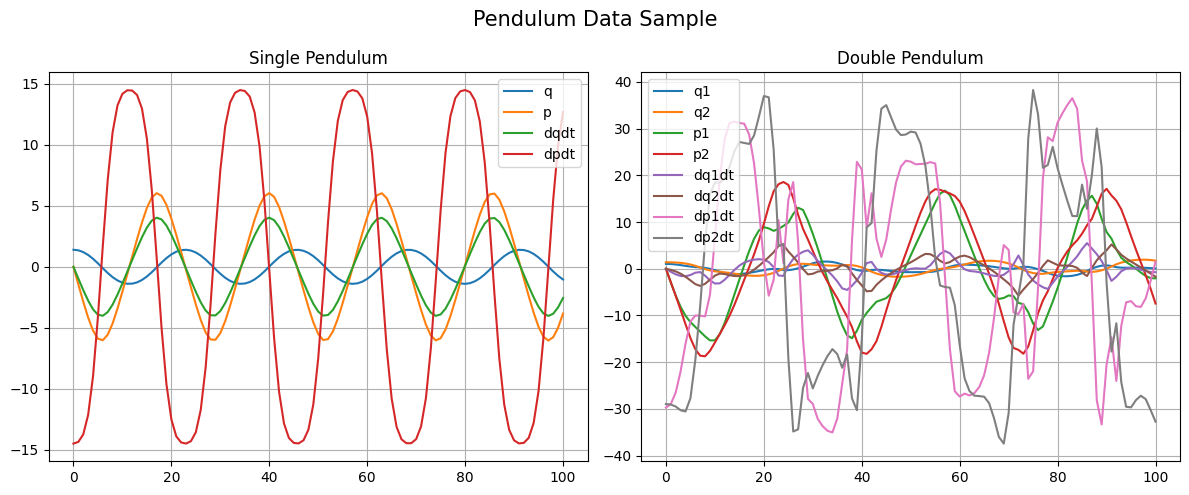

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
map_generalized_coord_momenta = {
    "Single Pendulum": X_single + y_single,
    "Double Pendulum": X_double + y_double,
}
for i, (k, v) in enumerate(map_generalized_coord_momenta.items()):
    ax = axes[i]
    df[v].loc[:100].plot(ax=ax)
    ax.grid()
    ax.set_title(k)
fig.suptitle("Pendulum Data Sample", size=15)
fig.tight_layout()
fig.savefig("fig/pendulum_data_sample2.png", dpi=200, facecolor="white")


# Single Pendulum


### Train


In [6]:
pendulum = "single"
X_vars = X_single
y_vars = y_single

# training data
[N_train, t_eval, t_span, y0, X_vars] = get_params(df=df, X_vars=X_vars)
X_train = df[X_vars][:N_train].to_numpy()
y_train = df[y_vars][:N_train].to_numpy()


In [7]:
train_spec0 = TrainSpec(mlg=mlg[pendulum], hamiltonian_method="curr", penalty_lamb=0)
train_spec1 = TrainSpec(mlg=mlg[pendulum], hamiltonian_method="next", penalty_lamb=0)




In [8]:
hnn1 = train_hnn(X_train, y_train, train_spec1)
hnn0 = train_hnn(X_train, y_train, train_spec0)
base = train_base_mlp(X_train, y_train, train_spec0)

ham0=-2.5526282117038774
itr=0, loss=68.8681235471976
itr=50, loss=8.3407429970299
itr=100, loss=1.1195740275587318
itr=150, loss=0.17191234814844453
itr=200, loss=0.01702382645726845
itr=250, loss=0.00152114196166956
itr=300, loss=0.0003413863925133096
itr=350, loss=0.000173168210899724
itr=400, loss=0.00010383874946323337
itr=450, loss=6.42403221646155e-05
itr=500, loss=4.0122605611053134e-05
itr=550, loss=2.5471840870407887e-05
itr=600, loss=1.6699793800746523e-05
itr=650, loss=1.1497232293963463e-05
itr=700, loss=8.407655154905852e-06
itr=750, loss=6.541401103463912e-06
itr=800, loss=5.372396603678893e-06
itr=850, loss=4.598729309611821e-06
itr=900, loss=4.051412168897546e-06
itr=950, loss=3.6374643752192947e-06
ham0=-2.5526282117038774
itr=0, loss=68.85906880570721
itr=50, loss=9.219622428276022
itr=100, loss=1.1770113087596217
itr=150, loss=0.16949376926996618
itr=200, loss=0.0151843041639437
itr=250, loss=0.0014995844350257858
itr=300, loss=0.00037326982515906203
itr=350, loss=0

In [9]:
hnn0_pred = integrate_hnn(model=hnn0, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
hnn1_pred = integrate_hnn(model=hnn1, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
base_pred = integrate_base_mlp(base, t_span, y0, t_eval=t_eval, rtol=rtol)


### Plot


In [10]:
col_energy_total = f"energy_total_{pendulum}"
df_base = (
    pd.DataFrame(base_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="base_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn0 = (
    pd.DataFrame(hnn0_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn0_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn1 = (
    pd.DataFrame(hnn1_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn1_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)

df_act = (
    df[X_vars]
    .loc[N_train:]
    .assign(case="actual")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_single_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_all = pd.concat(
    [
        df_act,
        df_base,
        df_hnn0,
        df_hnn1,
    ],
    axis=0,
)

In [11]:

# Error in (q, p)
df_err_qp = pd.concat(
    [
        (df_base[X_vars] - df_act[X_vars]).abs().assign(case="base_pred - actual"),
        (df_hnn0[X_vars] - df_act[X_vars]).abs().assign(case="hnn0_pred - actual"),
        (df_hnn1[X_vars] - df_act[X_vars]).abs().assign(case="hnn1_pred - actual"),
    ],
    axis=0,
)

# Error in total energy
df_err_energy = pd.concat(
    [
        (df_base[[col_energy_total]] - df_act[[col_energy_total]])
        .abs()
        .assign(case="base_pred - actual"),
        (df_hnn0[[col_energy_total]] - df_act[[col_energy_total]])
        .abs()
        .assign(case="hnn0_pred - actual"),
        (df_hnn1[[col_energy_total]] - df_act[[col_energy_total]])
        .abs()
        .assign(case="hnn1_pred - actual"),
    ],
    axis=0,
)

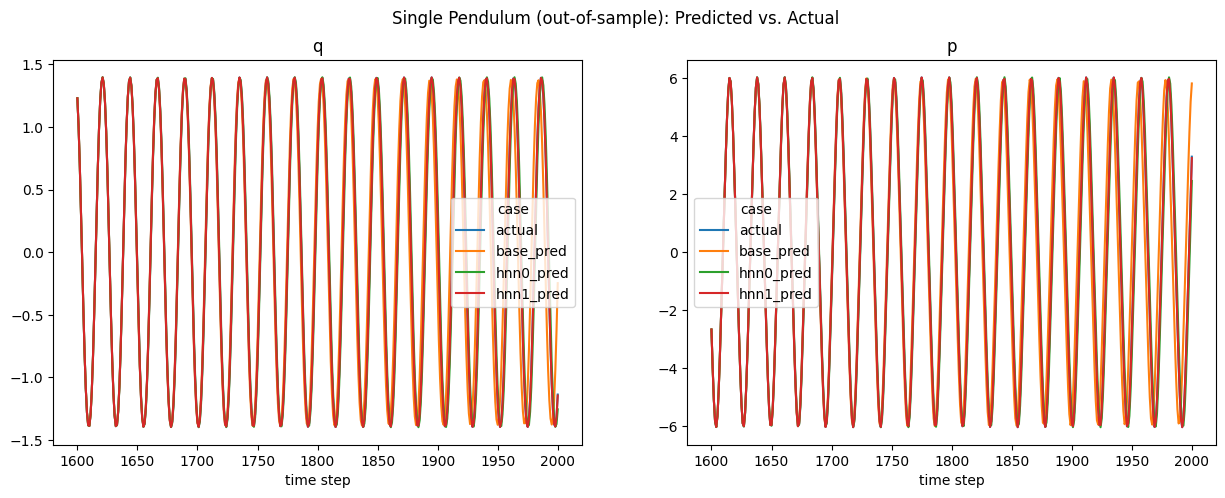

In [12]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(15, 2.5 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_all[X_vars + ["case"]].pivot_table(
        index=df_all.index, values=val, columns="case"
    )
    df_plot.plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
fig.suptitle("Single Pendulum (out-of-sample): Predicted vs. Actual")
fig.savefig("fig/hnn_single_pendulum_pred_act.png", dpi=200, facecolor="white")


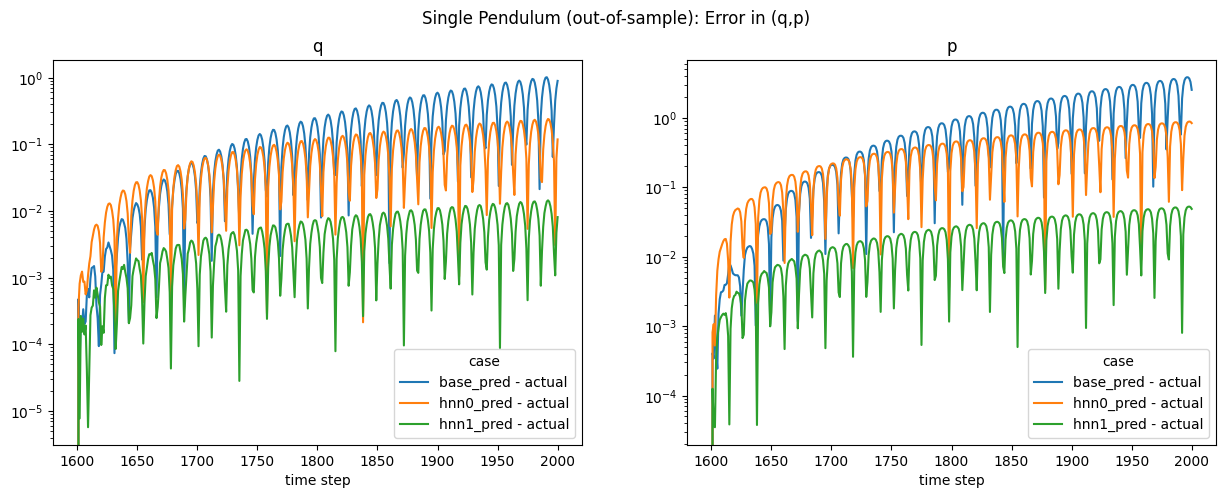

In [13]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(15, 2.5 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_err_qp[X_vars + ["case"]].pivot_table(
        index=df_err_qp.index, values=val, columns="case"
    )
    df_plot.plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
    ax.set_yscale("log")
fig.suptitle("Single Pendulum (out-of-sample): Error in (q,p)")
fig.savefig("fig/hnn_single_pendulum_error_qp.png", dpi=200, facecolor="white")


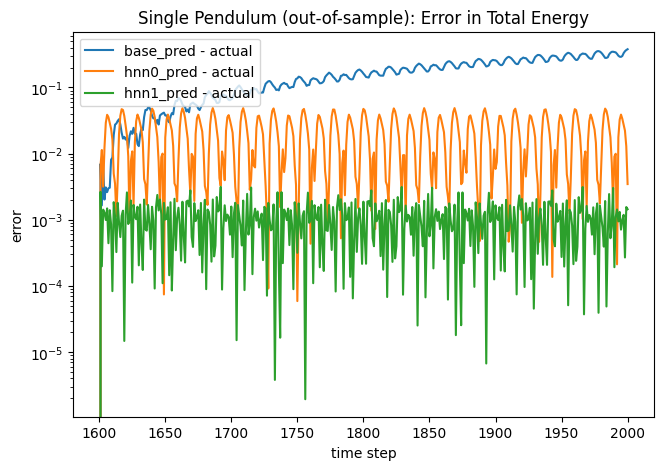

In [14]:
fig, ax = plt.subplots(figsize=(7.5, 2.5 * 2))
val = col_energy_total
df_plot = df_err_energy[[col_energy_total, "case"]].pivot_table(
    index=df_err_energy.index, values=val, columns="case"
)
df_plot.plot(ax=ax)
ax.set_title(val)
ax.set_xlabel("time step")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.legend(loc="upper left")
ax.set_title("Single Pendulum (out-of-sample): Error in Total Energy")
fig.savefig("fig/hnn_single_pendulum_error_energy.png", dpi=200, facecolor="white")


# Double Pendlum


### Train

In [8]:
pendulum = "double"
X_vars = X_double
y_vars = y_double

# training data
[N_train, t_eval, t_span, y0, X_vars] = get_params(df=df, X_vars=X_vars)
X_train = df[X_vars][:N_train].to_numpy()
y_train = df[y_vars][:N_train].to_numpy()


In [9]:
train_spec0 = TrainSpec(
    mlg=mlg[pendulum],
    learning_rate=0.0005,
    hidden_dims=[200, 200, 200],
    epochs=5000,
    hamiltonian_method="curr",
    penalty_lamb=0,
)
train_spec1 = TrainSpec(
    mlg=mlg[pendulum],
    learning_rate=0.0005,
    hidden_dims=[200, 200, 200],
    epochs=5000,
    hamiltonian_method="next",
    penalty_lamb=0.1,
)


In [10]:
base = train_base_mlp(X_train, y_train, train_spec0)
hnn1 = train_hnn(X_train, y_train, train_spec1)
hnn0 = train_hnn(X_train, y_train, train_spec0)

ham0=-22.25525642340776
itr=0, loss=320.2618775063612
itr=50, loss=294.7360742406654
itr=100, loss=168.14064739155464
itr=150, loss=121.81287316969386
itr=200, loss=49.82993383792971
itr=250, loss=32.083008532431315
itr=300, loss=23.062910981348697
itr=350, loss=14.945915677447578
itr=400, loss=7.482389600230549
itr=450, loss=3.0103240848661543
itr=500, loss=1.2162156437313631
itr=550, loss=0.6088347114529065
itr=600, loss=0.36732926949177036
itr=650, loss=0.24704492679060888
itr=700, loss=0.1792532673770927
itr=750, loss=0.1372557809467726
itr=800, loss=0.10944486868778862
itr=850, loss=0.08991536068806028
itr=900, loss=0.07580692395934249
itr=950, loss=0.06462157276460863
itr=1000, loss=0.055985098830826
itr=1050, loss=0.04900868394570327
itr=1100, loss=0.0438545197218114
itr=1150, loss=0.038673433520501795
itr=1200, loss=0.034516714614661326
itr=1250, loss=0.031122660895440357
itr=1300, loss=0.0283867709946636
itr=1350, loss=0.025823002609825917
itr=1400, loss=0.02357853052987018
it

In [11]:
rtol

1e-06

In [12]:
base_pred = integrate_base_mlp(base, t_span, y0, t_eval=t_eval, rtol=rtol)
hnn0_pred = integrate_hnn(model=hnn0, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)
hnn1_pred = integrate_hnn(model=hnn1, t_span=t_span, y0=y0, t_eval=t_eval, rtol=rtol)

### Plot

In [13]:
col_energy_total = f"energy_total_{pendulum}"
df_base = (
    pd.DataFrame(base_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="base_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn0 = (
    pd.DataFrame(hnn0_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn0_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_hnn1 = (
    pd.DataFrame(hnn1_pred["y"].T, columns=X_vars, index=df.loc[N_train:].index)
    .assign(case="hnn1_pred")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)

df_act = (
    df[X_vars]
    .loc[N_train:]
    .assign(case="actual")
    .assign(
        **{
            col_energy_total: lambda dx: calculate_double_pendulum_hamiltonian(
                mlg=mlg[pendulum], x=dx[X_vars].to_numpy().T
            )
        }
    )
)
df_all = pd.concat(
    [
        df_act,
        df_base,
        df_hnn0,
        df_hnn1,
    ],
    axis=0,
)

In [14]:

# Error in (q, p)
df_err_qp = pd.concat(
    [
        (df_base[X_vars] - df_act[X_vars]).abs().assign(case="base_pred - actual"),
        (df_hnn0[X_vars] - df_act[X_vars]).abs().assign(case="hnn0_pred - actual"),
        (df_hnn1[X_vars] - df_act[X_vars]).abs().assign(case="hnn1_pred - actual"),
    ],
    axis=0,
)

# Error in total energy
df_err_energy = pd.concat(
    [
        (df_base[[col_energy_total]] - df_act[[col_energy_total]])
        .abs()
        .assign(case="base_pred - actual"),
        (df_hnn0[[col_energy_total]] - df_act[[col_energy_total]])
        .abs()
        .assign(case="hnn0_pred - actual"),
        (df_hnn1[[col_energy_total]] - df_act[[col_energy_total]])
        .abs()
        .assign(case="hnn1_pred - actual"),
    ],
    axis=0,
)

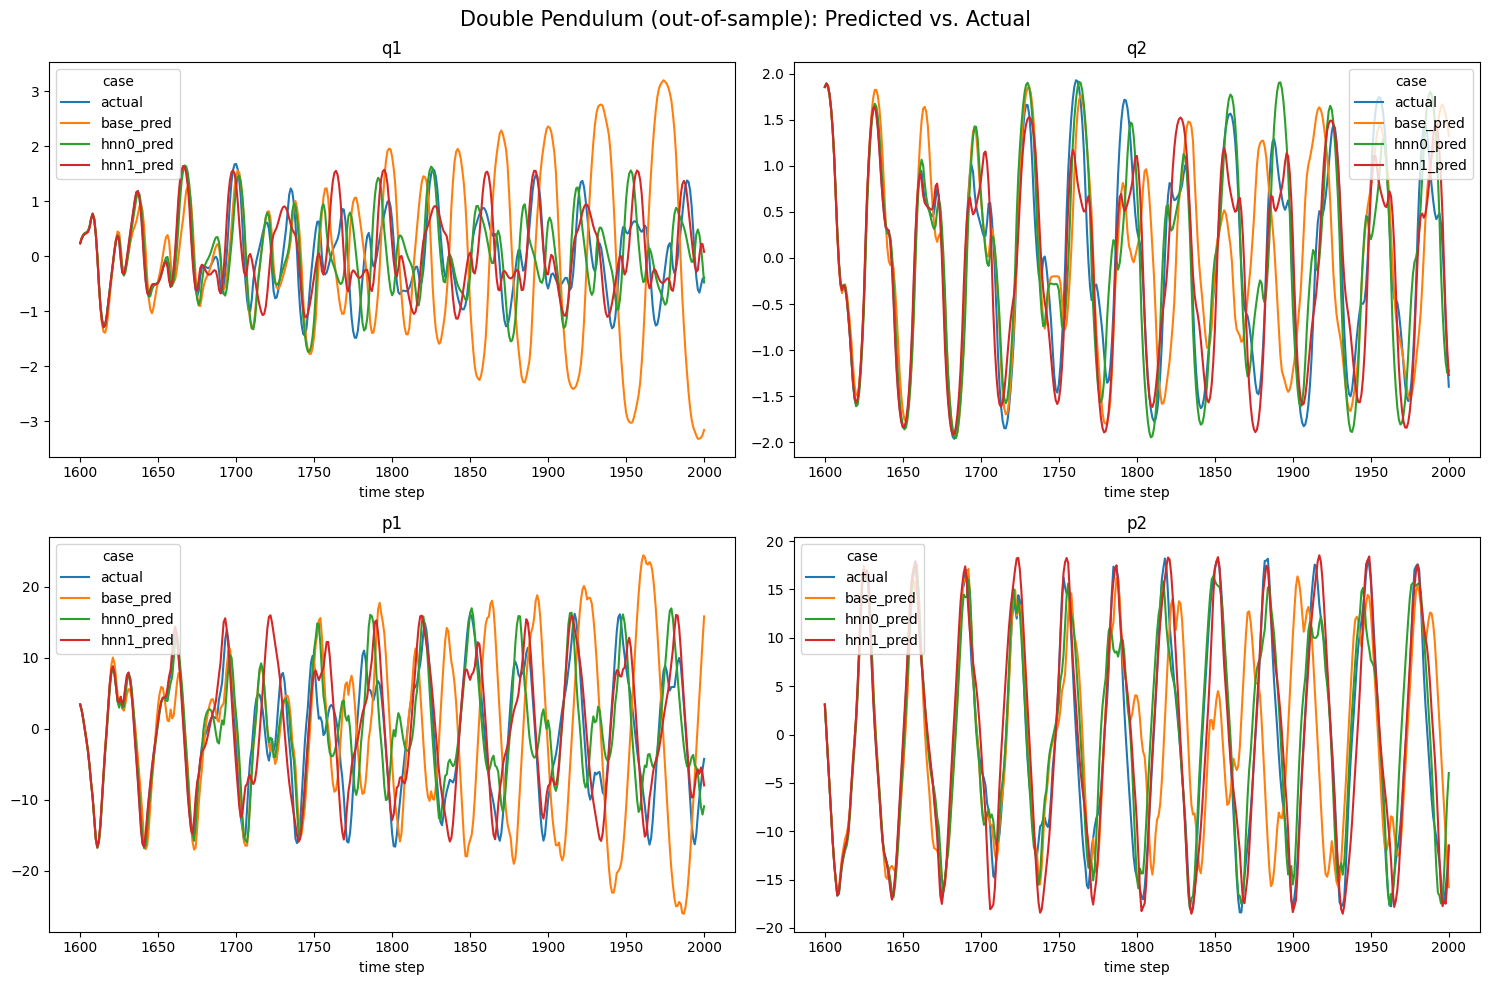

In [35]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(15, 2.5 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_all[X_vars + ["case"]].pivot_table(
        index=df_all.index, values=val, columns="case"
    )
    df_plot.plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
fig.suptitle("Double Pendulum (out-of-sample): Predicted vs. Actual",size=15)
fig.tight_layout()
fig.savefig("fig/hnn_double_pendulum_pred_act.png", dpi=200, facecolor="white")


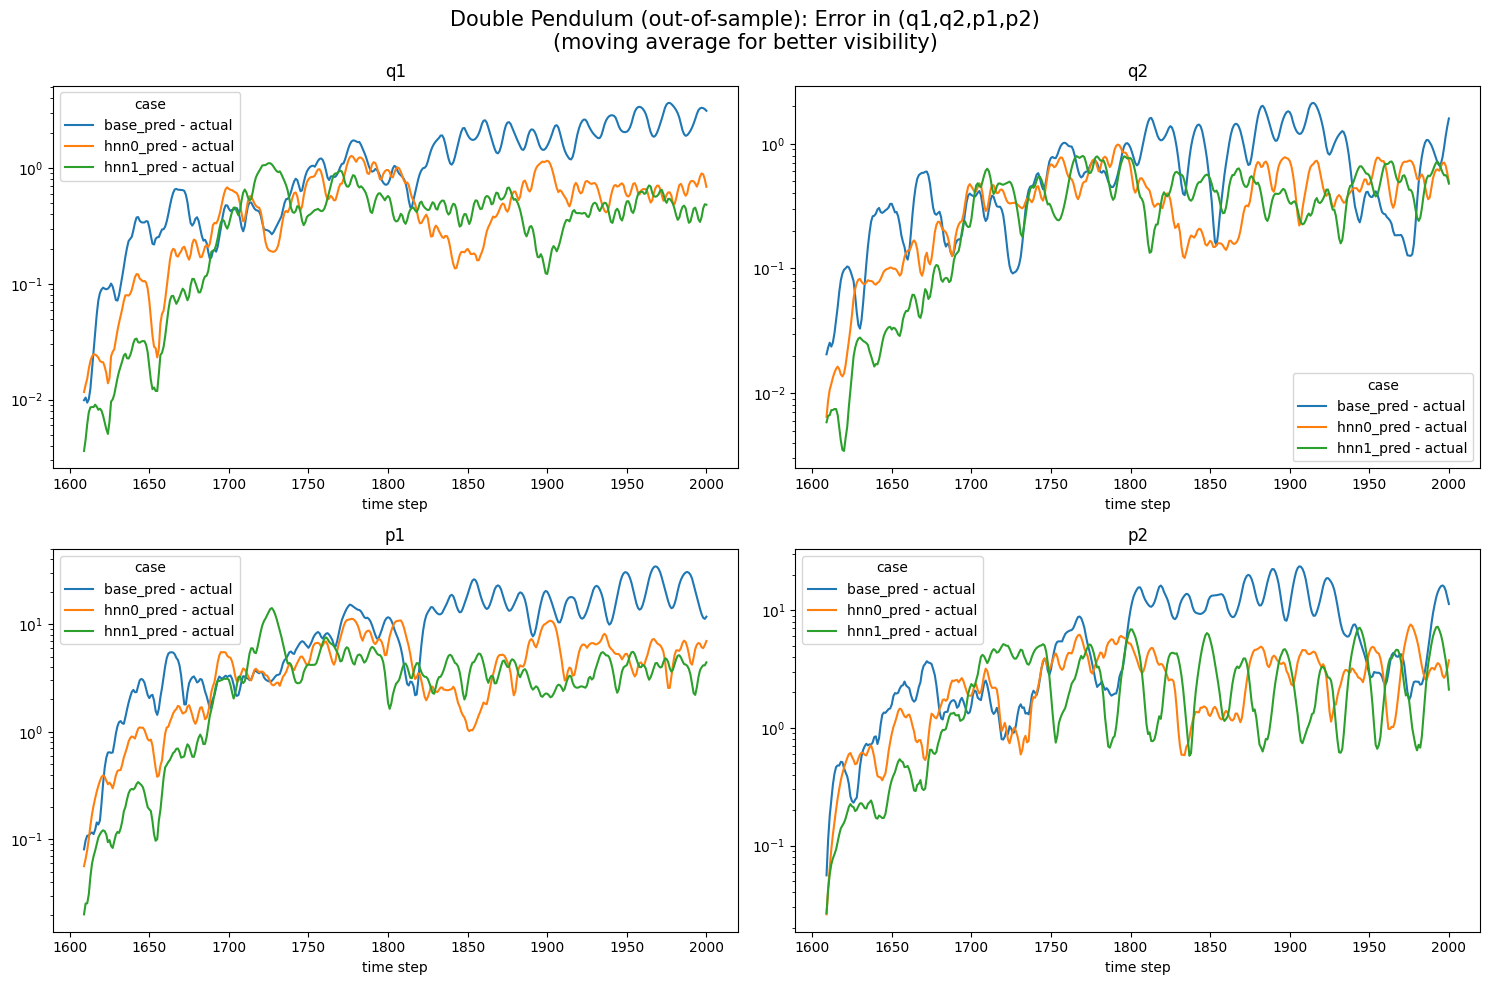

In [37]:
fig, axes = plt.subplots(int(len(X_vars) / 2), 2, figsize=(15, 2.5 * len(X_vars)))
for i, ax in enumerate(
    axes.reshape(
        len(X_vars),
    )
):
    val = X_vars[i]
    df_plot = df_err_qp[X_vars + ["case"]].pivot_table(
        index=df_err_qp.index, values=val, columns="case"
    )
    import numpy as np
    df_plot.rolling(10).mean().plot(ax=ax)
    ax.set_title(val)
    ax.set_xlabel("time step")
    ax.set_yscale("log")
fig.suptitle("Double Pendulum (out-of-sample): Error in (q1,q2,p1,p2)\n(moving average for better visibility)", size=15)
fig.tight_layout()
fig.savefig("fig/hnn_double_pendulum_error_qp.png", dpi=200, facecolor="white")


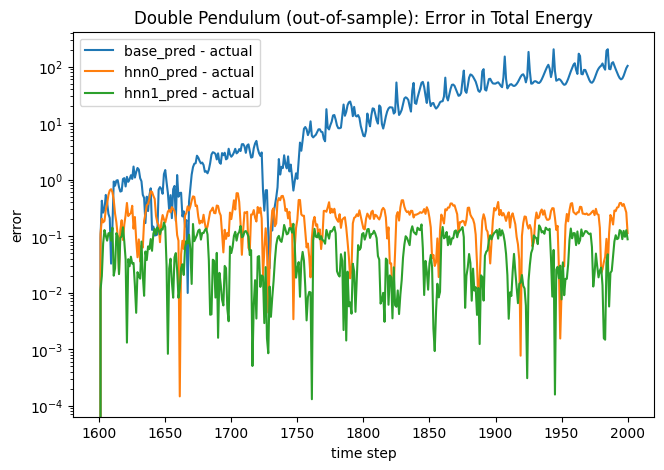

In [38]:
fig, ax = plt.subplots(figsize=(7.5, 2.5 * 2))
val = col_energy_total
df_plot = df_err_energy[[col_energy_total, "case"]].pivot_table(
    index=df_err_energy.index, values=val, columns="case"
)
df_plot.plot(ax=ax)
ax.set_title(val)
ax.set_xlabel("time step")
ax.set_ylabel("error")
ax.set_yscale("log")
ax.set_title("Double Pendulum (out-of-sample): Error in Total Energy")
ax.legend(loc="upper left")
fig.savefig("fig/hnn_double_pendulum_error_energy.png", dpi=200, facecolor="white")
